# Predicting chemical properties
- [Result is here](Chem_anal.ipynb)

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import joblib
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
import pandas as pd

def extra_split(sc_X,sc_y,extra_ratio=0.1):
    n_records=sc_X.shape[0]

    data_df=pd.DataFrame(sc_X)
    data_df["y"]=sc_y

    high_threshold_id = int(n_records*(1-extra_ratio))
    data_df=data_df.sort_values(by="y").reset_index(drop=True)
    tr_df=data_df.iloc[:high_threshold_id,:]
    te_df=data_df.iloc[high_threshold_id:,:]

    tr_X=tr_df.drop("y",axis=1)
    te_X=te_df.drop("y",axis=1)
    tr_y=tr_df["y"]
    te_y=te_df["y"]

    return np.array(tr_X),np.array(te_X),np.array(tr_y),np.array(te_y)

def shuffle_dataset(desc_df,n_total_records=32,y_label="expt"):
    desc_df=desc_df.sample(frac=1)
    y=desc_df[y_label][:n_total_records]
    X=desc_df.drop([y_label,"SMILES"],axis=1)[:n_total_records]
    y=np.array(y)

    return X,y


def split_X_y(X,y,x_dim=None,test_ratio=0.2,extra_mode=False):
    if x_dim is not None:
        pca = PCA(n_components=x_dim)
        comp_X=pca.fit_transform(X)
    else:
        comp_X=np.array(X)
    vmax=1


    scaler=MinMaxScaler
    scaler_X = scaler(feature_range=(-vmax,vmax))
    scaler_y = scaler(feature_range=(-1,1))

    sc_X=scaler_X.fit_transform(comp_X.reshape(-1,comp_X.shape[1]))
    sc_y=scaler_y.fit_transform(y.reshape(-1,1))

    if not extra_mode:
        tr_X,te_X,tr_y,te_y=train_test_split(sc_X,sc_y,test_size=test_ratio)
    else:
        tr_X,te_X,tr_y,te_y=extra_split(sc_X,sc_y,test_ratio)

    tr_y=tr_y.reshape(-1)
    te_y=te_y.reshape(-1)

    return tr_X,tr_y,te_X,te_y



def eval(model,tr_X,tr_y,te_X,te_y,plot=True):
    score_list=[]

    if plot:
        plt.figure(figsize=(2,2),dpi=150)
        plt.plot([-1,1],[-1,1],c="gray",linewidth=0.5,alpha=0.5)

    for (X,y),label in zip([(tr_X,tr_y),(te_X,te_y)],
    ("Train","Test")):

        y_pred =model.predict(X)
        y_pred[np.where(y_pred!=y_pred)]=0

        err=(mean_squared_error(y,y_pred))
        #print(err)
        score_list.append(err)

        if plot:

            plt.xlim(-1,1)
            plt.ylim(-1,1)

            #plt.figure()
            plt.scatter(y,y_pred,label=label,s=10)
            #print(label,y,y_pred)
    if plot:
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    return score_list

In [8]:
from QCLRegressor.regressors.StandardQCLRegressor import StandardQCLRegressor
from QCLRegressor.Encoders.XYEncoder import XYEncoder
from QCLRegressor.gates.Observable import ZObservable
from QCLRegressor.Encoders.prerocess import *
from QCLRegressor.gates.CNOTRotationGates import CNOTRotationGates

x_dim=8
n_qubit=x_dim
x_dim=4
n_qubit=x_dim*2

def qcl_model():
    depth=3
    model=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
    return model



In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF

import warnings
warnings.simplefilter('ignore')
import joblib
import json

db_path_dict={}
db_path_dict["ESOL"]="../dataset/database/ESOL.bin"
db_path_dict["MP"]="../dataset/database/Bradley.bin"
db_path_dict["Solv"]="../dataset/database/FreeSolv.bin"
db_path_dict["Lipo"]="../dataset/database/Lipo.bin"


default_trials=2000
default_trials/8

# set models
model_dict={}
#model_dict["QCL"]=qcl_model()
#model_dict["RFR"]=RandomForestRegressor()
#model_dict["SVR"]=SVR(kernel="rbf")
#model_dict["BYR"]=BayesianRidge()

#model_dict["PLS"]=PLSRegression(n_components=x_dim)

model_dict["GP(RBF+Dot+White)"]=GaussianProcessRegressor(kernel=RBF()+ DotProduct() + WhiteKernel())
res_dict={}

default_trials=2000


In [10]:
# check statistical performances
# if you train QCL, it takes will take a long time

current_time=time.strftime('%Y-%m-%d %H:%M:%S')
path=f"res/extra_8dim_gp{current_time}.json"
path=f"res/inner_4dim_gp{current_time}.json"
extra_mode=True
extra_mode=False

for n_total_records in tqdm([8,16,32,64,128,256,512]):
    for db_name,db_path in db_path_dict.items():
        desc_df=joblib.load(db_path)
        n_trials=int(default_trials/n_total_records)
        for i in range(n_trials):
            for model_name in model_dict:
                for dim in [x_dim,None]:
                    if (dim is None) and (model_name=="QCL"):
                        break

                    X,y=shuffle_dataset(desc_df,n_total_records=n_total_records,y_label="expt")
                    tr_X,tr_y,te_X,te_y=split_X_y(X,y,x_dim=dim,test_ratio=0.2,extra_mode=extra_mode)

                    model=model_dict[model_name]
                    model.fit(tr_X,tr_y)

                    temp_dict={}
                    temp_dict["Train"],temp_dict["Test"]=eval(model,tr_X,tr_y,te_X,te_y,plot=False)
                    
                    if dim is not None:
                        label=f"-{dim}-dim"
                    else:
                        label=""
                    temp_dict["Model"]=f"{model_name}{label}"
                    temp_dict["Records"]=n_total_records
                    temp_dict["Database"]=db_name
                    res_dict[f"{n_total_records}-{db_name}-{model_name}-{i}{label}"]=temp_dict

        with open(path,"w") as f:
            f.write(json.dumps(res_dict))

100%|██████████| 7/7 [02:30<00:00, 21.43s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

loss 0.020510348651939
loss 0.032396286351264
loss 0.027835329117157


100%|██████████| 1/1 [02:26<00:00, 146.60s/it]

loss 0.111931589929314


{'64-ESOL-QCL--8-dim': {'Train': 0.020510348651939056,
  'Test': 0.12153692146950362,
  'Model': 'QCL-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-ESOL-RFR--8-dim': {'Train': 0.007153801462908482,
  'Test': 0.12479621170855429,
  'Model': 'RFR-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-ESOL-SVR--8-dim': {'Train': 0.012970914101314972,
  'Test': 0.13887822690563703,
  'Model': 'SVR-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-ESOL-BYR--8-dim': {'Train': 0.029227405814822065,
  'Test': 0.06456725437654143,
  'Model': 'BYR-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-ESOL-PLS--8-dim': {'Train': 0.02896010047019666,
  'Test': 0.05566551864651225,
  'Model': 'PLS-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-ESOL-GP(RBF+Dot+White)--8-dim': {'Train': 0.018367620284087866,
  'Test': 0.06405810863392812,
  'Model': 'GP(RBF+Dot+White)-8-dim',
  'Records': 64,
  'Database': 'ESOL'},
 '64-MP-QCL--8-dim': {'Train': 0.03239628635126414,
  'Test': 0.496617856

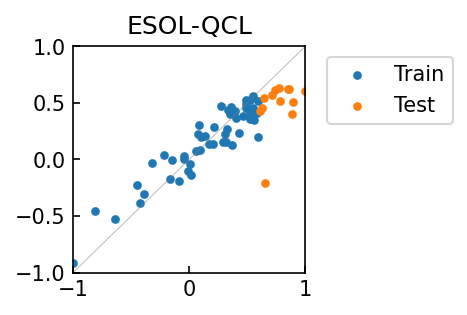

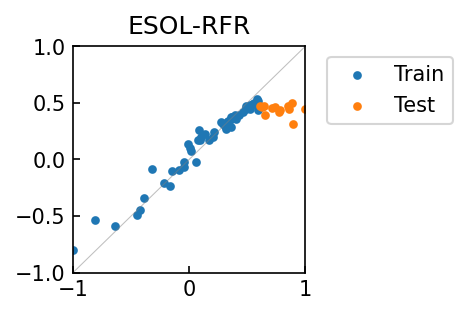

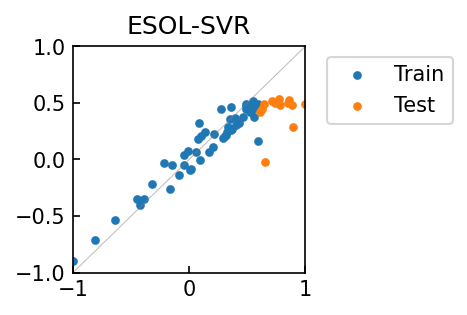

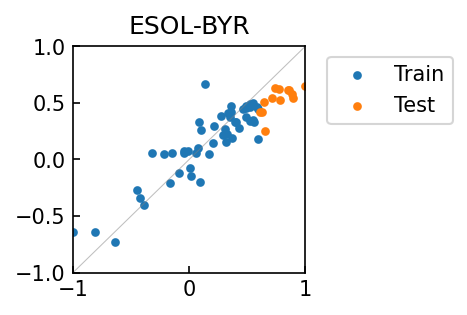

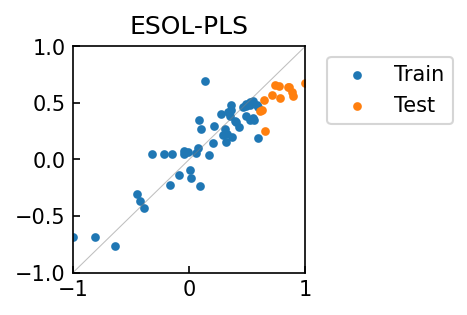

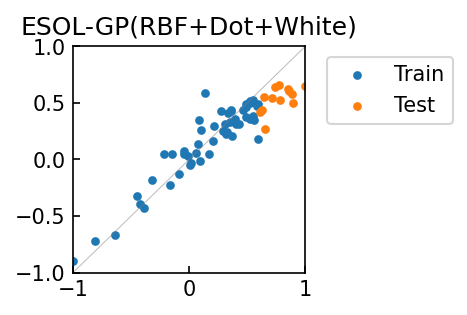

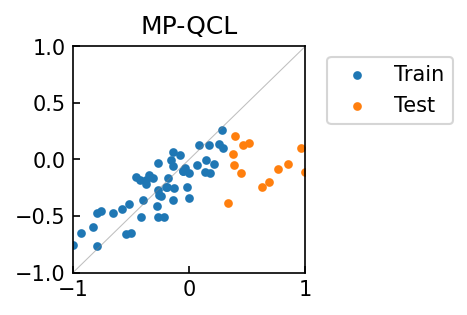

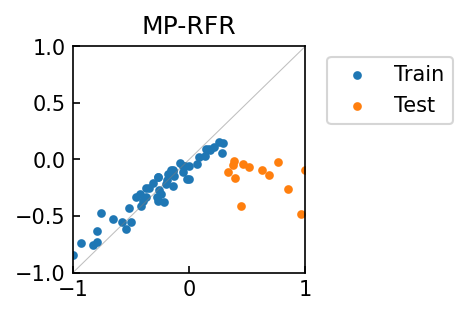

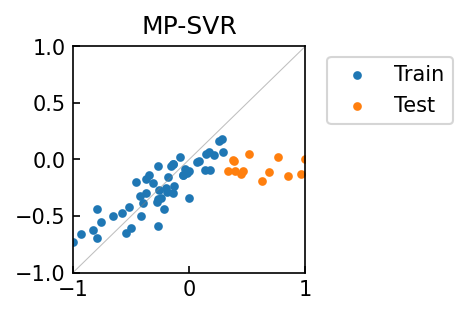

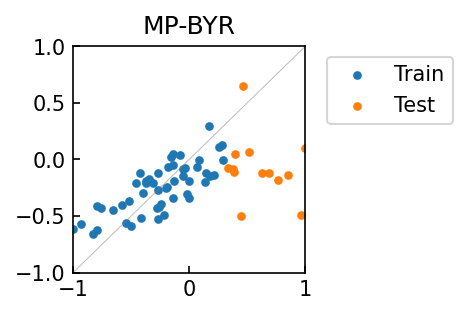

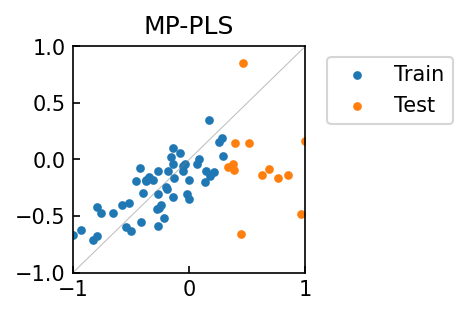

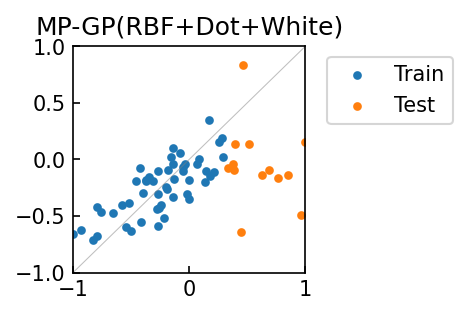

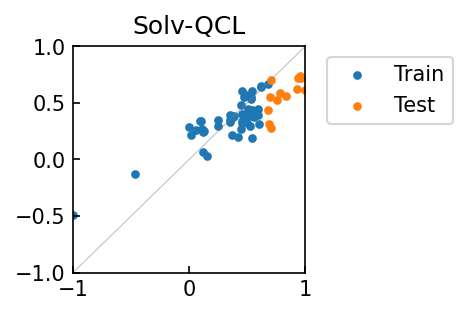

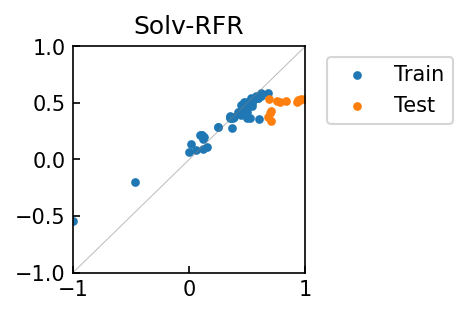

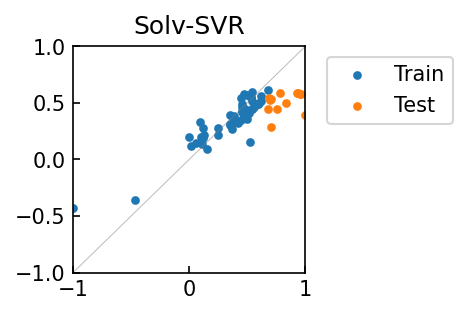

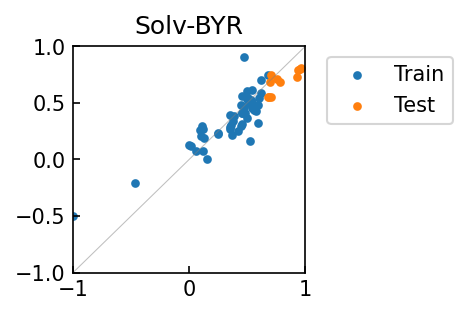

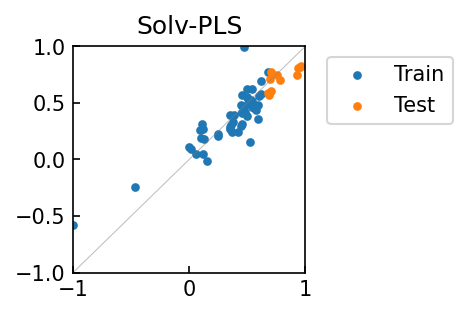

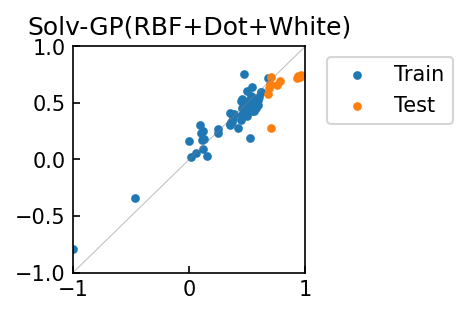

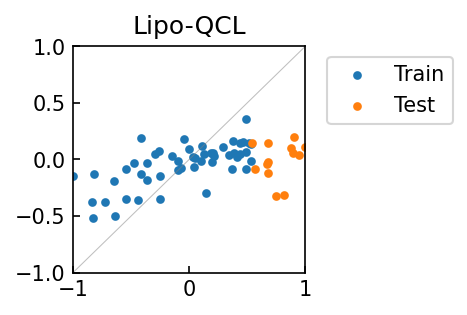

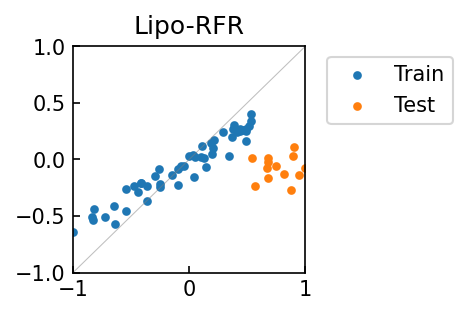

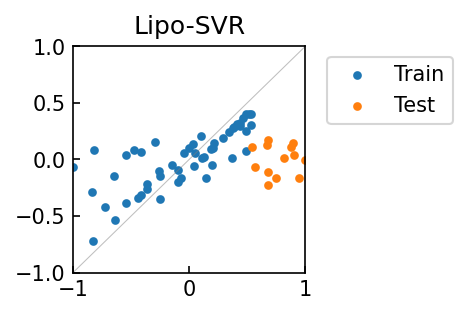

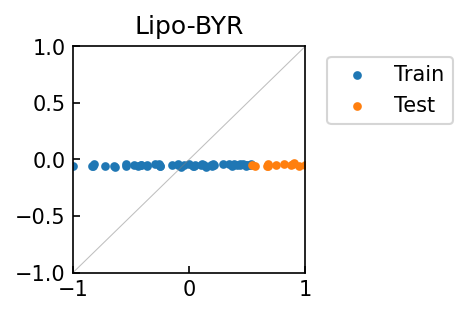

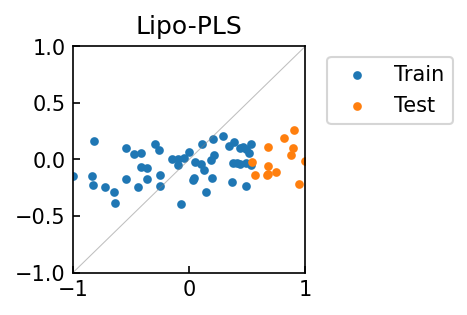

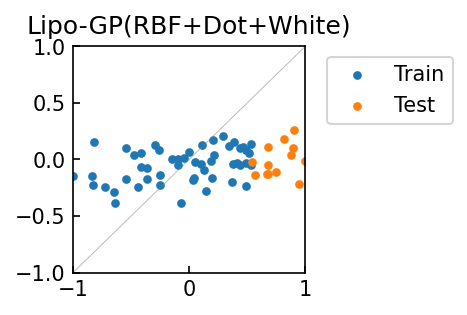

In [8]:
#plot
res_dict={}
model_dict={}
model_dict["QCL"]=qcl_model()
model_dict["RFR"]=RandomForestRegressor()
model_dict["SVR"]=SVR(kernel="rbf")
model_dict["BYR"]=BayesianRidge()
model_dict["PLS"]=PLSRegression(n_components=x_dim)
model_dict["GP(RBF+Dot+White)"]=GaussianProcessRegressor(kernel=RBF()+ DotProduct() + WhiteKernel())

db_path_dict={}
db_path_dict["ESOL"]="../dataset/database/ESOL.bin"
db_path_dict["MP"]="../dataset/database/Bradley.bin"
db_path_dict["Solv"]="../dataset/database/FreeSolv.bin"
db_path_dict["Lipo"]="../dataset/database/Lipo.bin"


extra_mode=True
dim=x_dim

for n_total_records in tqdm([64]):
#for n_total_records in tqdm([8,16,32,64,128,256,512]):
    for db_name,db_path in db_path_dict.items():
        desc_df=joblib.load(db_path)
        X,y=shuffle_dataset(desc_df,n_total_records=n_total_records,y_label="expt")
        tr_X,tr_y,te_X,te_y=split_X_y(X,y,x_dim=dim,test_ratio=0.2,extra_mode=extra_mode)


        for model_name in model_dict:
            for dim in [x_dim]:
                if (dim is None) and (model_name=="QCL"):
                    break

                model=model_dict[model_name]
                model.fit(tr_X,tr_y)

                temp_dict={}
                temp_dict["Train"],temp_dict["Test"]=eval(model,tr_X,tr_y,te_X,te_y,plot=True)
                plt.title(f"{db_name}-{model_name}")
                
                if dim is not None:
                    label=f"-{dim}-dim"
                else:
                    label=""
                temp_dict["Model"]=f"{model_name}{label}"
                temp_dict["Records"]=n_total_records
                temp_dict["Database"]=db_name
                res_dict[f"{n_total_records}-{db_name}-{model_name}-{label}"]=temp_dict
                break
res_dict